# One-Dimensional Climate Models: Brown Dwarfs w/ Clouds in Chemical Equilibrium

In this tutorial you will learn how to run 1-D climate models for brown dwarfs with Virga clouds included self-consistently! 

You should already be familiar with running 1-D climate models with running a [simple clear brown dwarf model](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html)

What you need to have downloaded for clouds to work: 
[Virga](https://natashabatalha.github.io/virga/installation.html) and be sure to have the mieff files downloaded as well!


In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import virga.justdoit as vj
import virga.justplotit as cldplt
jpi.output_notebook()
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray
from bokeh.plotting import show, figure

Loading BokehJS ...

We're going to set up the climate run exactly like we would a clear model which you have done before, defining the pre-weighted ck table and initiating the climate inputs

In [2]:
#1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

ck_db = os.path.join(os.getenv('picaso_refdata'),'opacities', 'preweighted', f'sonora_2020_feh{mh}_co_{CtoO}.data.196')

# #sonora bobcat cloud free structures file
sonora_profile_db = os.path.join(os.getenv('picaso_refdata'),'sonora_grids','bobcat', 'structures_m+0.0')

In [3]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation

teff= 200 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db, method='preweighted') # grab your opacities

For this case, we're going to start off with a Sonora Bobcat profile

In [4]:
nlevel = 91 # number of plane-parallel levels in your code

pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)

In [5]:
# for the sake of time in this tutorial, I set it to a higher layer because I know where it should be in this case. 
# In general for clouds it is better to start deeper in the atmosphere and work your way up. It just takes a lot more time unfortunately.
rcb_guess = 52 # top most level of guessed convective zone 

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

If you are unfamiliar with Virga, we highly recommend going through the [tutorials](https://natashabatalha.github.io/virga/tutorials.html) to understand the basics of how we generate those clouds before pairing them with the 1-D climate models here. It is also necessarry to have the mieff files generated for the cloud species you want to include.

In [6]:
# virga_dir = '//Users/nbatalh1/Documents/data/virga' # path to virga directory with the Mie scatering files
virga_dir = os.path.join("/Users", "adityasengupta",'virga', "refrind") # path to virga directory with the Mie scattering files

Below, we run Virga as normal to initiate our cloud run. Note, though the function is identical when we run `virga` here in climate, we are just doing it to initiate our inputs. So this virga run does not actually compute a cloud in this cell. The cloud model will run within the climate code. 

In [7]:
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      rcb_guess=rcb_guess, rfacv = rfacv)
#cl_run.atmosphere(cold_trap=True)
cl_run.inputs["climate"]["cloudy"] = "selfconsistent"
# We could keep this as the top-level interface or we could put it into inputs_climate
cl_run.virga(condensates = ['H2O'],directory = virga_dir, mh=1,fsed = 8.0, latent_heat=True)

In [8]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=False)

SUMMARY
-------
Clouds: selfconsistent
quench False
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Overwriting some Kz values to minimum value set by kz_min 
                     You can always turn off these warnings by setting verbose=False
Doing clouds: Max TAUCLD diff is 6.289532498764554  Tau tolerance is  1.2579064997529108
Iteration number  0 , min , max temp  76.9388039787225 1201.8927451711493 , flux balance  -0.35334889630116767
Iteration number  1 , min , max temp  78.8373805407808 1202.2235759665643 , flux balance  -0.35257854157018975
Iteration number  2 , min , max temp  80.62556377785901 1202.5824562969915 , flux balance  -0.35174209027210657
Iteration number  3 , min , max temp  82.32010374565914 1202.9716811150938 , flux balance  -0.

## Plot the P-T Profile

Before we plot the PT profile of the model, we want to grab the condensation curve for H2O just to help us visualize where in the atmosphere we expect the cloud to start forming. To the left of this condensation curve is where we expect the H2O vapour to condense into a cloud.

In [9]:
h2o_cond_p, h2o_cond_t = vj.condensation_t('H2O', 1, 2.2, pressure = out['pressure'])

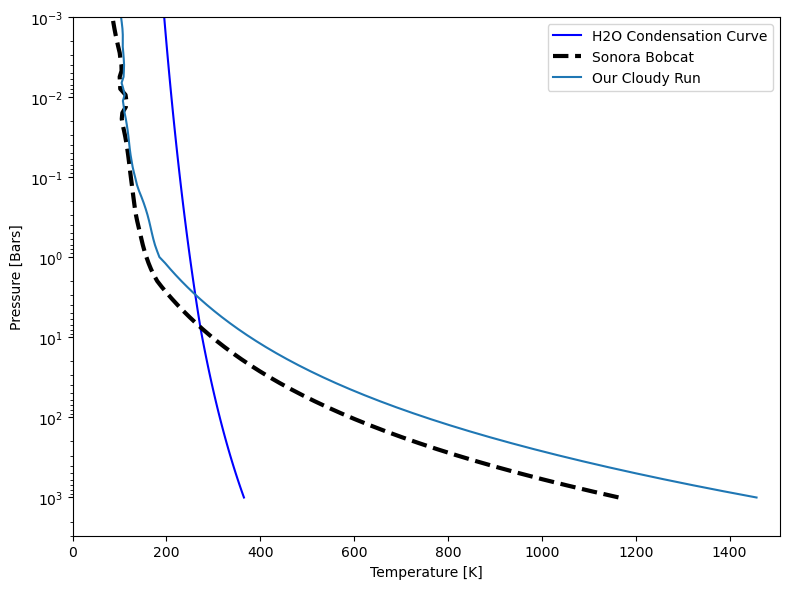

In [10]:
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)
plt.figure(figsize=(8,6))
plt.ylabel("Pressure [Bars]")
plt.xlabel('Temperature [K]')
plt.xlim(0,max(out['temperature'])+50)
plt.ylim(3e3,1e-3)

plt.plot(h2o_cond_t,h2o_cond_p, 'b', label = 'H2O Condensation Curve')
plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat")

plt.semilogy(out['temperature'],out['pressure'],label="Our Cloudy Run")

plt.legend()
plt.tight_layout()
plt.show()

Now you should be able to see a mostly smooth PT profile that's a little warmer than the cloud-free Sonora Bobcat profile. Even though it looks warmer, the actual effective temperature of the object is the same because the water cloud opacity blocks out some of the flux. 

As you may know (or will find out) clouds are really difficult to converge models for especially with H2O clouds in cold regions for example. To learn more about common signs that you should look for to identify "bad" models, take a look at the [Common Climate Issues Notebook]()

## Looking at the Cloud Properties

If you look at the climate output now, you will notice a couple of new keys in the dictionary that helps you look at the cloud properties

In [11]:
out.keys()

dict_keys(['pressure', 'temperature', 'ptchem_df', 'dtdp', 'cvz_locs', 'flux_ir_attop', 'fnet/fnetir', 'converged', 'flux_balance', 'cld_df', 'virga_output', 'all_profiles', 'all_opd', 'all_kzz'])

`cld_df` and `virga_output` are the two important dictionary key outputs for cloudy runs. `cld_df` is in the format to be used to generate spectra.

In [12]:
out['cld_df']

,opd,w0,g0,pressure,wavenumber
0,0.0,0.0,0.0,0.000195,37331.820150
1,0.0,0.0,0.0,0.000195,34848.475344
2,0.0,0.0,0.0,0.000195,32051.251233
3,0.0,0.0,0.0,0.000195,29670.297718
4,0.0,0.0,0.0,0.000195,27619.029732
...,...,...,...,...,...
17635,0.0,0.0,0.0,918.619692,185.599999
17636,0.0,0.0,0.0,918.619692,135.699994
17637,0.0,0.0,0.0,918.619692,102.300002
17638,0.0,0.0,0.0,918.619692,72.049997


`virga_output` can then be directly used with virga functions to easily visualize the properties as well. For more details about these individual properties and how to interpret them, please take a look at the [Analyzing Your Runs](https://natashabatalha.github.io/virga/notebooks/3_AnalyzingRuns.html) virga tutorial.

In [13]:
show(cldplt.all_optics_1d(out['virga_output'], wave_range=[1,2]))

In [14]:
show(cldplt.all_optics(out['virga_output']))

In [15]:
show(cldplt.opd_by_gas(out['virga_output']))

In [16]:
show(cldplt.condensate_mmr(out['virga_output']))

## Cloudy vs Clear Spectra

Now we can generate the spectrum for the cloudy run. This is exactly like how we generate any other thermal emission spectrum except this time we add in the cloud profile. (You may have done this before if you've tried to use a post-processed virga cloud)

In [17]:
opa_mon = jdi.opannection(wave_range=[0.3,15])

hi_res = jdi.inputs(calculation="browndwarf") # start a calculation
teff= 200 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s
hi_res.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity

hi_res.atmosphere(df=out['ptchem_df'])

# now let's add the cloud optical properties
hi_res.clouds(df=out['cld_df'])

df_spec = hi_res.spectrum(opa_mon, calculation='thermal',full_output=True)

#converts from picaso default units (can also specify original unit if different from picaso via kwarg f_unit and xgrid_unit)
fluxnu= jdi.convert_flux_units(df_spec['wavenumber'], df_spec['thermal'], to_f_unit = 'erg*cm^(-2)*s^(-1)*Hz^(-1)')

df_spec['fluxnu'] = fluxnu
wno,fp = jdi.mean_regrid(df_spec['wavenumber'], fluxnu, R=200) #wavenumber, erg/cm2/s/Hz


In [18]:
jpi.show(jpi.spectrum(wno,fp,x_axis_type='log',y_axis_type='log'))

Now let's load in a Sonora Bobcat spectrum to compare what it looks like. This specific case has been included in this directory for ease of access but to compare other temperatures you will have to download the full [Sonora Bobcat](https://zenodo.org/records/5063476) set of models

In [19]:
teff = 200
grav = 1000

wave_bobcat,flux_bobcat = np.loadtxt(f"sp_t200g1000nc_m0.0",
                            usecols=[0,1],unpack=True, skiprows = 2)

In [20]:
# now let's regrid the spectra to R=200 to make sure the two spectra are on the same grid
wno_bobcat, fp_bobcat = jdi.mean_regrid(1e4/wave_bobcat,flux_bobcat,R=200)

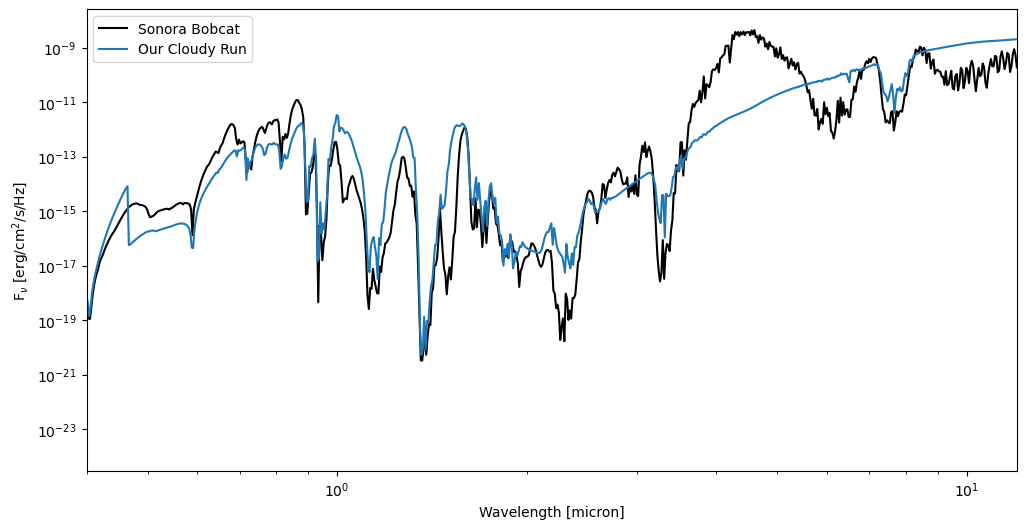

In [21]:
fig = plt.figure(figsize=(12,6))
plt.loglog(1e4/wno_bobcat,fp_bobcat, 'k', label = 'Sonora Bobcat')
plt.loglog(1e4/wno,fp, label = 'Our Cloudy Run')
plt.xlabel('Wavelength [micron]')
plt.ylabel('F$_\\nu$ [erg/cm$^2$/s/Hz]')
plt.xlim(0.4,12)
plt.legend()
plt.show()

So here you can see the large water cloud feature around 4-5 micron where the flux from this brown dwarf is being surpressed by the large water cloud opacity. Other water features can also be seen in other regions of the spectrum.

## Patchy Clouds

Clouds are hard...Sometimes they don't behave nicely with static 1-D climate models. To alleviate this or to represent the reality that clouds may not be uniformly covering the entire atmosphere, where we see variability in brown dwarfs, we can run patchy clouds! For more on this, you can  read [Morley et al. 2014a](https://ui.adsabs.harvard.edu/abs/2014ApJ...787...78M/abstract) and [Morley et al. 2014b](https://ui.adsabs.harvard.edu/abs/2014ApJ...789L..14M/abstract)

Here we're going to initiate a new climate calculation:

In [22]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation

teff= 200 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db,method='preweighted') # grab your opacities

In [23]:
rcb_guess = 52 # top most level of guessed convective zone 
# for the sake of time of this tutorial, I set it to 60 because I know where it should be in this case. In general for clouds it is better
# to start deeper in the atmosphere and work your way up. It just takes more time.

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

Here we include a few new parameters for patchy clouds
1. `do_holes` : (bool) Default = False. Turn on/off patchy clouds
2. `fhole` : (float) This is a value between 0 and 1. E.g. 0.9 represents 90% clear and 10% cloudy 
3. `fthin_cld` : (float) This is a value between 0 and 1, it allows you to make the clear column have the slightest of clouds. 0 is completely clear, 1 is completely cloudy

Typically, it's easier to think about this using just fhole and ignoring fthin_cld. Use fthin_cld only if you're trying to really model complex systems with multiple cloud thicknesses or to build an intuition about clouds!

We can initialize the inputs just like before except we are making `do_holes = True` and `fhole = 0.5`

In [27]:
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      rcb_guess=rcb_guess, rfacv = rfacv)

cl_run.atmosphere(cold_trap=True)
cl_run.inputs["climate"]["cloudy"] = "selfconsistent"
cl_run.virga(condensates = ['H2O'],directory = virga_dir, mh=1,fsed = 8.0,
             do_holes = True, fhole = 0.5, fthin_cld = 0, latent_heat=True)

In [28]:
out_patchy = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

SUMMARY
-------
Clouds: selfconsistent
quench False
cold_trap True
vol_rainout False
no_ph3 False
Moist Adiabat: False
cold_trap=True; Adjusting cold trap
I am thinning the cloud with a fractional component: 0
I am updating kzz. This could be either because clouds were requested (which always use self consistent kzz) or because self consistent kzz profiles were requested for chemistry.
I dont have fluxes, let me compute them
Overwriting some Kz values to minimum value set by kz_min 
                     You can always turn off these warnings by setting verbose=False
Doing clouds: Max TAUCLD diff is 6.28955623949191  Tau tolerance is  1.257911247898382
I am thinning the cloud with a fractional component: 0
Iteration number  0 , min , max temp  76.9058247298799 1201.6677023528325 , flux balance  -0.11892275391315464
Iteration number  1 , min , max temp  78.78915457587416 1201.7521510135364 , flux balance  -0.11856064470903901
Iteration number  2 , min , max temp  80.57113311458517 1201.8

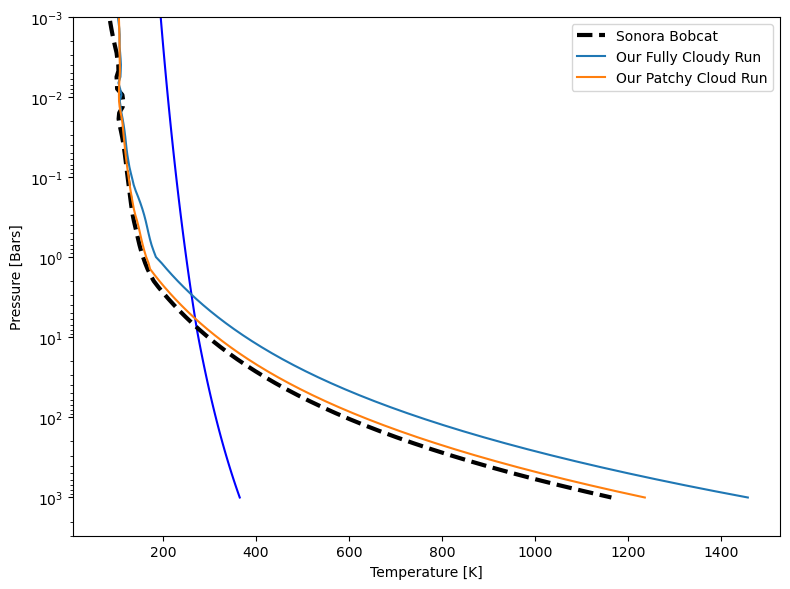

In [29]:
# now let's plot the results! 
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)
plt.figure(figsize=(8,6))
plt.ylabel("Pressure [Bars]")
plt.xlabel('Temperature [K]')
#plt.xlim(0,max(out['temperature'])+50)
plt.ylim(3e3,1e-3)

plt.plot(h2o_cond_t,h2o_cond_p, 'b')#, label = 'H2O Condensation Curve')
plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat")

plt.semilogy(out['temperature'],out['pressure'],label="Our Fully Cloudy Run")
plt.semilogy(out_patchy['temperature'],out_patchy['pressure'],label="Our Patchy Cloud Run")

plt.legend()
plt.tight_layout()
plt.show()

What you should notice here, because the patchy clouds reduces the amount of cloud opacity in the atmosphere, the PT profile is not shifted to be as warm as the fully cloudy model but is rather closer to the cloud-free Sonora Bobcat profile

In [30]:
opa_mon = jdi.opannection(wave_range=[0.3,15])

hi_res = jdi.inputs(calculation="browndwarf") # start a calculation
teff= 200 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s
hi_res.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity

hi_res.atmosphere(df=out_patchy['ptchem_df'])

# now let's add the cloud optical properties, this time with arguments to make sure we take into consideration the patchy cloud parameters
hi_res.clouds(df=out_patchy['cld_df'], do_holes=True, fhole = 0.3, fthin_cld=0)

df_spec = hi_res.spectrum(opa_mon, calculation='thermal',full_output=True)
#converts from picaso default units (can also specify original unit if different from picaso via kwarg f_unit and xgrid_unit)
fluxnu= jdi.convert_flux_units(df_spec['wavenumber'], df_spec['thermal'], to_f_unit = 'erg*cm^(-2)*s^(-1)*Hz^(-1)')

df_spec['fluxnu'] = fluxnu
wno_patchy,fp_patchy= jdi.mean_regrid(df_spec['wavenumber'], fluxnu, R=200) #wavenumber, erg/cm2/s/Hz

I am thinning the cloud with a fractional component: 0


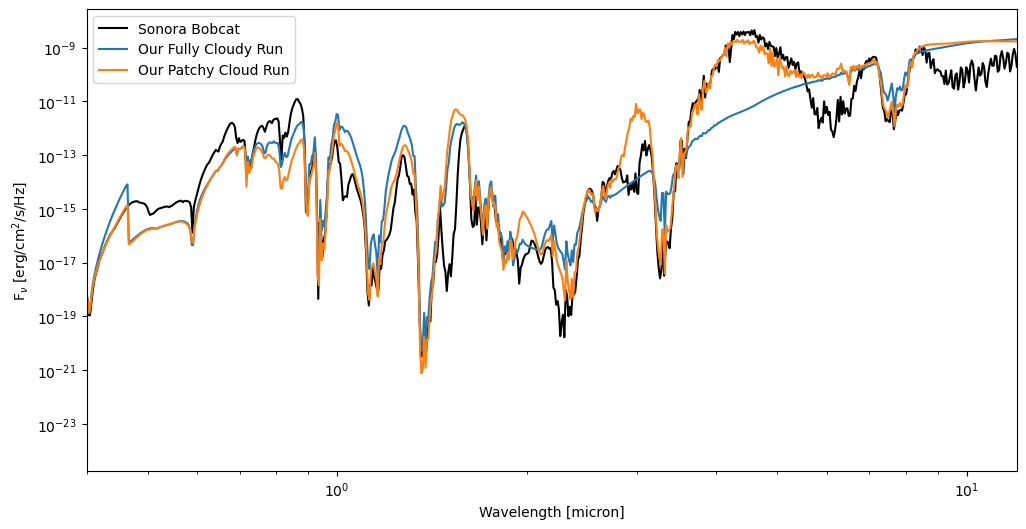

In [31]:
fig = plt.figure(figsize=(12,6))
plt.loglog(1e4/wno_bobcat,fp_bobcat, 'k', label = 'Sonora Bobcat')
plt.loglog(1e4/wno,fp, label = 'Our Fully Cloudy Run')
plt.loglog(1e4/wno_patchy,fp_patchy, label = 'Our Patchy Cloud Run')
plt.xlabel('Wavelength [micron]')
plt.ylabel('F$_\\nu$ [erg/cm$^2$/s/Hz]')
plt.xlim(0.4,12)
plt.legend()
plt.show()

In comparison to the fully cloudy model, you can see that even at 50% cloudy that the water cloud feature at 4-5 micron isn't as distinct as the 100% cloudy model. You can, however, see in the other H2O band windows that the 50% cloudy model finds itself, as we expect, between a fully clear model, and a fully cloudy model.